好きな用途に利用できるnotebookです。  
データの可視化や簡単なモデルの構築などにご利用下さい。

## 必要なライブラリのimport

In [2]:
# 必要なライブラリ等をインポート
import warnings
import time
import sys
import datetime
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [5]:
# メモリーを削減する関数を作成
def reduce_mem_usage(df, verbose=True):
    # データの型の一覧を作成
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # 最初の状態のメモリーの合計をMbで計算
    start_mem = df.memory_usage().sum() / 1024**2
    # データフレームの各カラムの方を小さいメモリで済むように変更する
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)   
    # 変換後のメモリ使用量をMbで計算
    end_mem = df.memory_usage().sum() / 1024**2
    # Trueにしていたら、変換後のメモリ使用量と何パーセント削減できたかを出力
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## データの読み込み

In [6]:
# 2つのtransactionデータを読み込む。purchase_dateを日付型として読み込む。
new_transactions = pd.read_csv('../data/raw/new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('../data/raw/historical_transactions.csv',
                                      parse_dates=['purchase_date'])

# authorized_flagとcategory_1のYとNを1と0に置き換える関数を作成。
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

# 上の関数を実行
historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [7]:
# データを読み込む関数を作成
# first_active_monthを日付型に変換
# 2018-02-01からfirst_active_monthの日数の差を表すelapsed_timeカラムを作成
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (pd.Timestamp('2018-02-01') - df['first_active_month']).dt.days
    return df

# trainとtestデータを読み込んで変換
train = read_data('../data/raw/train.csv')
test = read_data('../data/raw/test.csv')

# targetにtrainデータのtargetを代入し、trainデータからtargetカラムを削除
target = train['target']
del train['target']

## 特徴量作成

In [8]:
# 今日とpurchase_dateの日数差を抽出し、30でわることにより、月数差を抽出
# それにmonth_lagを足す
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [9]:
# データの確認
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,76
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,77
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,77
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,77
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,77


In [10]:
# get_dummies ワンホットエンコーディングに変換 = カテゴリ変数ごとにフラグを立てる
# category_2,_3に対してフラグを立てる
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

# メモリを削減
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

# [特徴量5]データフレームauth_meanを作成
# カードidごとに決済完了フラグの平均を算出し、カラム名を整える
agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

# データフレームauthorized_transactionsを作成。決済完了しているもののみを抽出
# historical_transactionsを決済完了していないもののみ残す
authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [11]:
auth_mean[:5]

,card_id,authorized_flag_mean
0,C_ID_00007093c1,0.765101
1,C_ID_0001238066,0.975610
2,C_ID_0001506ef0,0.939394
3,C_ID_0001793786,0.875000
4,C_ID_000183fdda,0.951389


In [12]:
# 決済日を決済月に変換
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [13]:
authorized_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,76,True,False,False,False,False,True,False,False,6
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,77,True,False,False,False,False,True,False,False,7
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,77,True,False,False,False,False,True,False,False,8
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,77,True,False,False,False,False,True,False,False,9
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,77,True,False,False,False,False,True,False,False,3


In [14]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,purchase_month
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,16,37,77,True,False,False,False,False,True,False,False,4
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,16,16,77,True,False,False,False,False,True,False,False,9
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,16,16,77,True,False,False,False,False,True,False,False,9
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,9,2,76,True,False,False,False,False,True,False,False,2
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,16,34,77,True,False,False,False,False,True,False,False,7


In [17]:
# 関数aggregate_transactionsを作成
# purchase_dateをエポック秒に変換
# agg_history : カードidごとに各カテゴリの平均や合計、idのユニークな数等を抽出。カラム名を整える
# df : カードidごとに行数を抽出、カラム名をtransactions_countにする。
# dfとagg_historyをカードidでleft join (innerでもよい？？)

def aggregate_transactions(history):
    
    history['purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [18]:
# [特徴量1]上の関数でhistorical_transactionsを変換して、各カラム名にhist_をつける
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,0.828571,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,76.828571
1,C_ID_0001238066,3,0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,1.000000,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,76.333333
2,C_ID_0001506ef0,4,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,0.250000,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,77.000000
3,C_ID_0001793786,27,2,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,0.185185,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,80.851852
4,C_ID_000183fdda,7,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.428571,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,76.428571


In [19]:
# [特徴量2]上の関数でauthorized_transactionsを変換して、各カラム名にauth_をつける
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,0.842105,0.157895,28,18,3,4,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,76.807018
1,C_ID_0001238066,120,2,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,0.708333,0.266667,65,29,6,18,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,76.633333
2,C_ID_0001506ef0,62,0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,0.000000,0.000000,28,19,2,3,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,76.870968
3,C_ID_0001793786,189,0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,0.000000,0.000000,114,45,4,9,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,80.814815
4,C_ID_000183fdda,137,4,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,0.729927,0.240876,71,34,7,9,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,76.788321


In [20]:
# [特徴量3]上の関数でnew_transactionsを変換して、各カラム名にnew_をつける
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328613,-0.664307,-0.656738,-0.671875,0.010703,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,77.000000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.850159,-0.571160,-0.078308,-0.740723,0.173412,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,76.538462
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011739,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,77.000000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,14,-0.229002,-0.007387,3.130859,-0.737793,0.947299,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,80.290323
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.590820,-0.599165,-0.107666,-0.732422,0.182870,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,76.727273


In [34]:

# intermediate_group : カードidとmonth_lagごとにpurchase_amountとinstallmentsを集計し、カラム名を整える
# final_group : カードidごとにintermediate_groupのmanth_lagと「purchase_amountとinstallmentsに関する集計情報」の
### 平均と標準偏差を抽出し、カラム名を整える


def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [35]:
# [特徴量4]authorized_transactionsに上の関数を適用
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,0.041293,-0.126683,0.446167,0.197339,0.120199,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,0.002699,-0.160977,0.485869,0.151393,0.093832,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,0.011212,0.161333,0.748701,0.496308,0.415117,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496068,4.018810,-0.005687,0.271221,-0.646277,0.166230,2.190924,1.290775,0.880276,0.259048,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316093,4.800612,-0.489227,0.141015,-0.728405,0.009876,1.151797,1.062785,0.472149,0.315407,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557396,2.089708,-0.685118,0.071894,-0.728885,0.016051,-0.425292,0.813979,0.108521,0.208719,4.076923,4.290717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,0.030670,-0.546063,0.092512,0.076295,0.051724,6.090909,3.505839,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909524,-0.740077,0.002424,-0.742206,0.003025,-0.737762,0.002652,0.003165,0.001086,2.666667,1.224745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,0.020383,-0.210304,1.127668,0.213951,0.442601,3.500000,1.772811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,0.026047,-0.387276,0.222295,0.107390,0.060790,9.166667,4.665476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
def successive_aggregates(df, field1, field2):

    # t:カードidとfield1ごとにfield2の平均を算出
    t = df.groupby(['card_id', field1])[field2].mean()

    # u:tをカードidごとに集計しなおし、field2に関する集計を行う。
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])

    # uのカラム名を整え、uを出力する
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [24]:
successive_aggregates(new_transactions, 'category_1', 'purchase_amount')[:5]

,card_id,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std
0,C_ID_00007093c1,-0.664307,-0.664307,-0.664307,NaN
1,C_ID_0001238066,-0.607362,-0.650146,-0.564578,0.060506
2,C_ID_0001506ef0,-0.723633,-0.723633,-0.723633,NaN
3,C_ID_0001793786,-0.007387,-0.007387,-0.007387,NaN
4,C_ID_000183fdda,-0.599165,-0.599165,-0.599165,NaN


In [30]:
#[特徴量6]
#additional_fields:上の関数を使用して、new_transactionsをcategory_1とpurchase_amountに関して集計を行う
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')

#上の関数を使用して、new_transactionsをinstallmentsとpurchase_amountに関して集計を行い、additional_fieldsに外部結合する
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')

#上の関数を使用して、new_transactionsをcity_idとpurchase_amountに関して集計を行い、additional_fieldsに外部結合する
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')

#上の関数を使用して、new_transactionsをcategory_1とinstallmentsに関して集計を行い、additional_fieldsに外部結合する
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')


#####全部innerでもいい気がする

In [31]:
additional_fields[:5]

,card_id,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,C_ID_00007093c1,-0.664307,-0.664307,-0.664307,NaN,-0.664307,-0.664307,-0.664307,NaN,-0.664307,-0.671875,-0.656738,0.010703,1.000000,1.000000,1.000000,NaN
1,C_ID_0001238066,-0.607362,-0.650146,-0.564578,0.060506,-0.423858,-0.625791,-0.151978,0.222020,-0.558222,-0.666829,-0.472066,0.072649,2.479167,1.458333,3.500000,1.443676
2,C_ID_0001506ef0,-0.723633,-0.723633,-0.723633,NaN,-0.723633,-0.723633,-0.723633,NaN,-0.723633,-0.723633,-0.723633,NaN,0.000000,0.000000,0.000000,NaN
3,C_ID_0001793786,-0.007387,-0.007387,-0.007387,NaN,-0.007387,-0.007387,-0.007387,NaN,-0.247054,-0.572876,0.249268,0.346825,0.000000,0.000000,0.000000,NaN
4,C_ID_000183fdda,-0.599165,-0.599165,-0.599165,NaN,-0.491244,-0.696208,-0.107666,0.233865,-0.572119,-0.605176,-0.539062,0.046749,1.454545,1.454545,1.454545,NaN


In [33]:
train[:5]

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92


In [36]:
# データの結合:trainとtestデータの説明変数をまとめる

#[特徴量1]
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

#[特徴量2]
train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

#[特徴量3]
train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

#[特徴量4]
train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

#[特徴量5]
train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

#[特徴量6]
train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

# features:trainデータのカラム名をcard_idとfirst_active_month以外を格納
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]

# categorical_feats:説明変数にあるカラム名feature_2とfeature_3を格納しておく
categorical_feats = ['feature_2', 'feature_3']

In [37]:
train[:5]

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_mean,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.692308,0.307692,0.000000,12.0,10.0,1.0,2.0,7.0,-8.571723,-0.659363,-0.431922,-0.737892,0.098851,4.0,0.307692,1.0,0.0,0.48

## モデルの学習

In [38]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [39]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import time
import pickle

# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=15)

#0ベクトルを作成
oof = np.zeros(len(train))
predictions = np.zeros(len(test))

start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(params=param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)])

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    # モデルを保存
    with open(f'../src/models/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.77614
[200]	valid_0's rmse: 3.72839
[300]	valid_0's rmse: 3.70533
[400]	valid_0's rmse: 3.69302
[500]	valid_0's rmse: 3.68593
[600]	valid_0's rmse: 3.68128
[700]	valid_0's rmse: 3.67798
[800]	valid_0's rmse: 3.67594
[900]	valid_0's rmse: 3.67478
[1000]	valid_0's rmse: 3.67378
[1100]	valid_0's rmse: 3.67301
[1200]	valid_0's rmse: 3.67268
[1300]	valid_0's rmse: 3.67246
[1400]	valid_0's rmse: 3.67204
[1500]	valid_0's rmse: 3.67183
[1600]	valid_0's rmse: 3.67199
Early stopping, best iteration is:
[1483]	valid_0's rmse: 3.67176
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.70522
[200]	valid_0's rmse: 3.66188
[300]	valid_0's rmse: 3.64154
[400]	valid_0's rmse: 3.63071
[500]	valid_0's rmse: 3.62485
[600]	valid_0's rmse: 3.62167
[700]	valid_0's rmse: 3.61957
[800]	valid_0's rmse: 3.6178
[900]	valid_0's rmse: 3.61688
[1000]	valid_0's rmse: 3.61597
[1100

## 特徴量重要度の確認

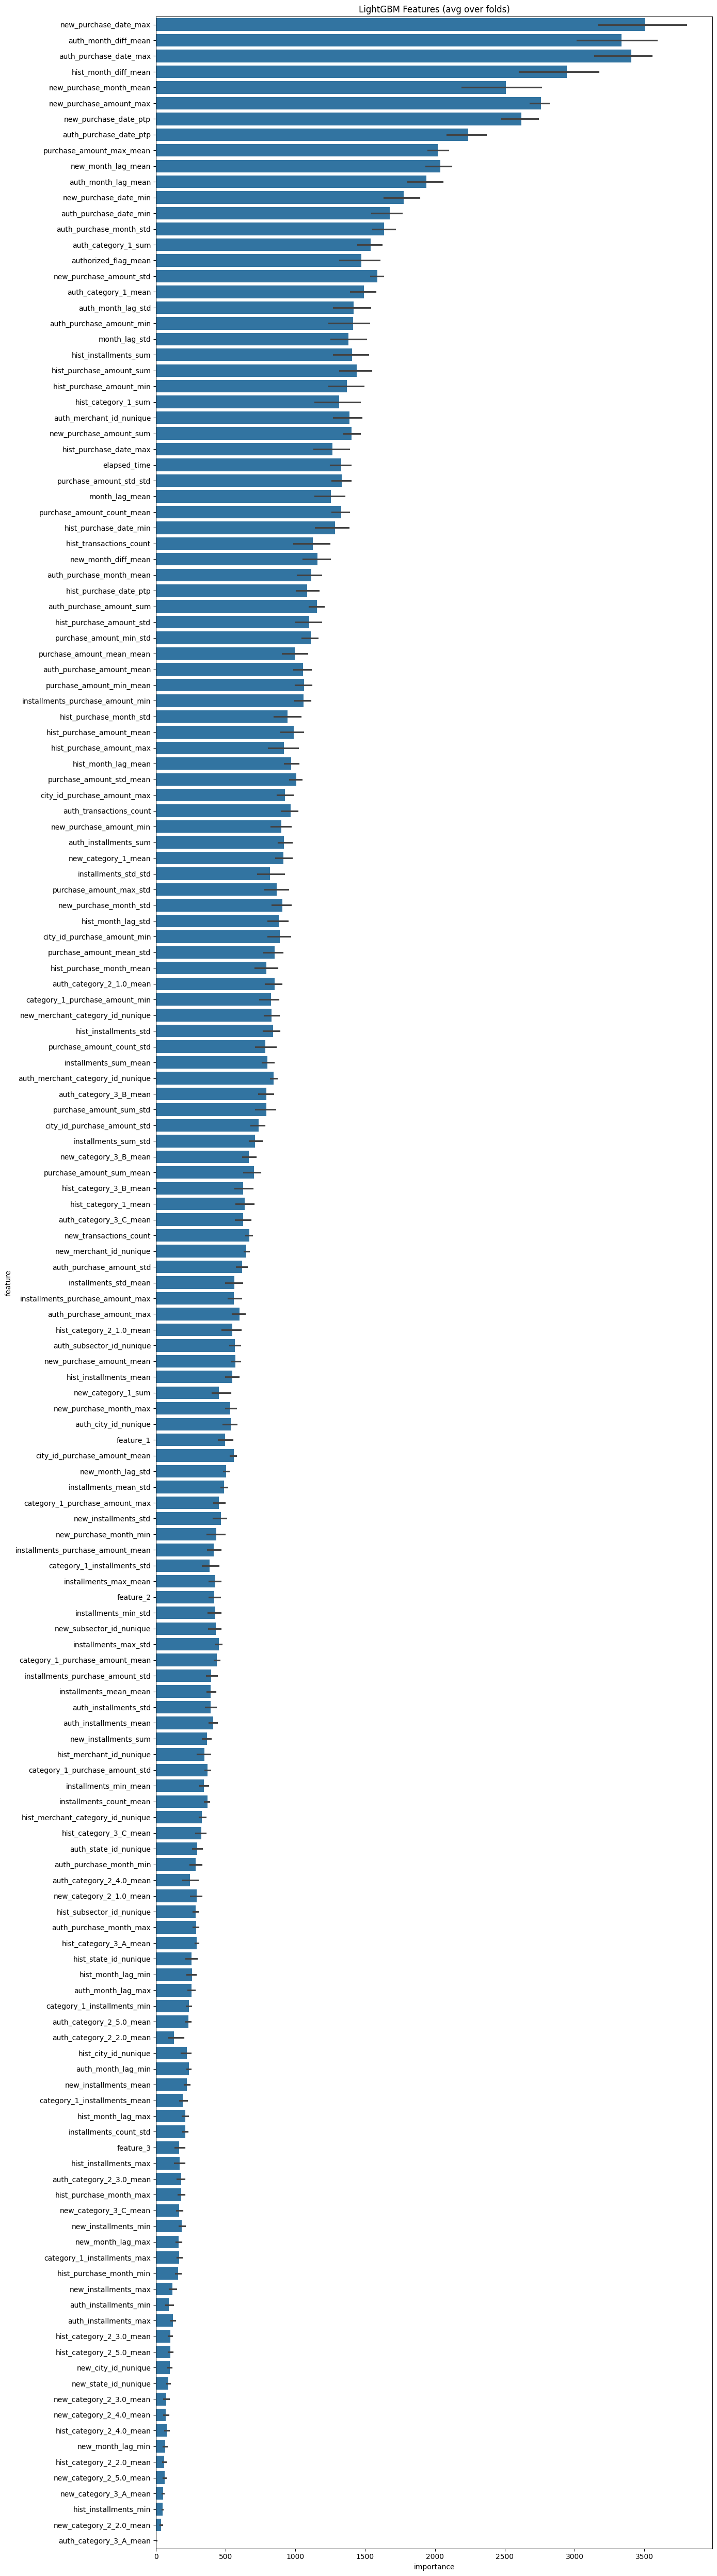

In [43]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

## 提出ファイルの作成

In [22]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit2.csv", index=False)